# 05. Análisis de Sensibilidad del Modelo Financiero

## Objetivo

En el notebook anterior (`04_analisis_financiero`), determinamos que la mejor estrategia de entrenamiento era un modelo **XGBoost** con un **`amount_factor=20`**. Este modelo logró minimizar el coste financiero esperado bajo las condiciones estándar (Pérdida por FN = 90%, Coste por FP = 5€).

Sin embargo, los costes de negocio pueden variar o ser estimaciones. Este notebook realiza un **Análisis de Sensibilidad** para responder:
1.  ¿Cómo cambia el **Umbral de Decisión Óptimo** si varían los costes de inspección?
2.  ¿Cómo afecta esto al **Coste Financiero Final**?

In [4]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib

# 1. Obtiene la ruta absoluta del directorio padre (la raíz del proyecto)
# '..' significa "ir una carpeta atrás"
project_root = os.path.abspath('..')

# 2. Añade esa ruta al sistema de búsqueda de Python si no está ya
if project_root not in sys.path:
    sys.path.append(project_root)


from src.load_data import load_fraud_csv, load_credit_scoring_data
from src.train_model import train_model_with_cost
from src.evaluate import best_threshold_by_cost # Importamos la función (¡actualizada!)


In [2]:
# --- 1. Cargar Datos ---
print("Cargando datos...")
df, X, y = load_fraud_csv('../data/credit_card.csv')
amount = X['Amount']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
amount_train = X_train['Amount']
amount_test = X_test['Amount']
print("Datos cargados y divididos.")

Cargando datos...
Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados y divididos.


In [3]:
# --- 2. Entrenar el MEJOR modelo (solo 1 vez) ---
# Usamos el ganador del notebook anterior: amount_factor = 20
BEST_FACTOR = 20
print(f"Entrenando el modelo XGBoost con el factor óptimo ({BEST_FACTOR})...")
xgb_best_model = train_model_with_cost(X_train, y_train, amount_train, model_type = "xgb", amount_factor=BEST_FACTOR)

# --- 3. Obtener las probabilidades (solo 1 vez) ---
print("Obteniendo probabilidades del set de prueba...")
y_proba = xgb_best_model.predict_proba(X_test)[:, 1]

print("Setup completado.")

Entrenando el modelo XGBoost con el factor óptimo (20)...
Model XGB trained (factor=20)
Obteniendo probabilidades del set de prueba...
Setup completado.


## 2. Simulación de Escenarios de Negocio

No necesitamos re-entrenar el modelo, ya que el `amount_factor=20` ya le ha enseñado al modelo la importancia relativa de los importes.

Utilizaremos las **probabilidades predichas (`y_proba`)** por ese modelo óptimo y ejecutaremos la función de optimización de umbrales (`best_threshold_by_cost`) variando los parámetros de negocio:
* **`inspect_cost` (Coste FP):** Probaremos un rango detallado `[1, 2, 3, 4, 5, 10, 20]` euros para encontrar puntos de inflexión.
* **`fraud_loss` (Coste FN):** Probaremos `[70%, 80%, 90%, 100%]` del importe perdido.

In [4]:
# --- 4. Definir los escenarios de negocio a probar ---
inspection_costs = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 4, 5, 10, 20]  # Coste de 1€, 5€, 10€, 20€ por Falso Positivo
fraud_loss_factors = [0.7, 0.8, 0.9, 1.0] # Se pierde el 70%, 80%, 90% o 100% del importe en un Falso Negativo

results = []

print("Iniciando análisis de sensibilidad...")

# --- 5. Bucle anidado para probar todas las combinaciones ---
for loss in fraud_loss_factors:
    for cost in inspection_costs:
        
        # Encontrar el mejor umbral y coste PARA ESTE ESCENARIO
        # Esta función ahora debe aceptar los parámetros de coste
        best_thr, min_cost = best_threshold_by_cost(
            y_test, 
            y_proba, 
            amount_test, 
            fraud_loss=loss,  # Pasamos el nuevo parámetro
            inspect_cost=cost # Pasamos el nuevo parámetro
        )
        
        results.append({
            'fraud_loss_pct': f"{loss*100:.0f}%",
            'inspect_cost_eur': cost,
            'best_threshold': best_thr,
            'min_expected_cost': min_cost
        })

print("Análisis completado.")

# Convertir a DataFrame para fácil visualización
sensitivity_df = pd.DataFrame(results)

Iniciando análisis de sensibilidad...
Análisis completado.


In [5]:
# Mostrar la tabla de resultados
display(sensitivity_df)

,fraud_loss_pct,inspect_cost_eur,best_threshold,min_expected_cost
0,70%,1.00,0.405960,1287.904
1,70%,1.25,0.405960,1289.154
2,70%,1.50,0.405960,1290.404
3,70%,1.75,0.782121,1290.877
4,70%,2.00,0.782121,1290.877
5,70%,2.25,0.782121,1290.877
6,70%,2.50,0.782121,1290.877
7,70%,2.75,0.782121,1290.877
8,70%,3.00,0.782121,1290.877
9,70%,4.00,0.782121,1290.877


## 3. Resultados del Análisis de Sensibilidad

A continuación, visualizamos cómo se adaptan el umbral y el coste mínimo a las diferentes realidades del negocio mediante mapas de calor (*heatmaps*).

### 3.1. Impacto en el Umbral de Decisión (El "Interruptor")

El siguiente gráfico revela un hallazgo fundamental sobre la estrategia de despliegue del modelo. Muestra el umbral de probabilidad (`predict_proba`) que debemos elegir para minimizar pérdidas.

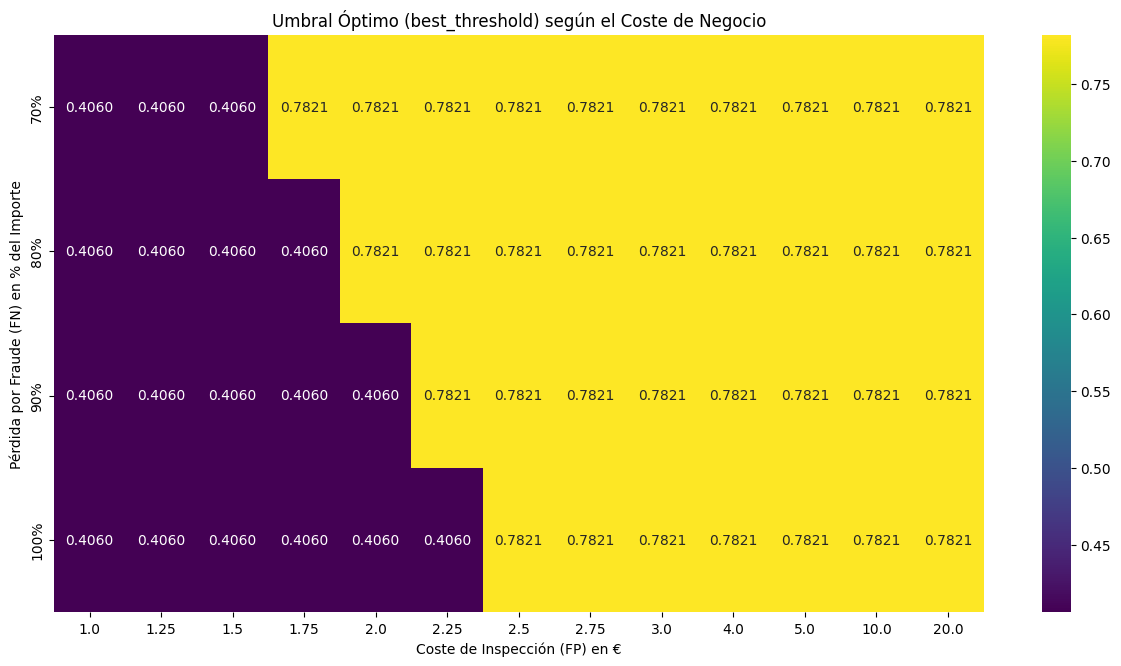

In [6]:

if not os.path.exists('../results'):
    os.makedirs('../results')

# Pivotar la tabla para el heatmap de umbrales
threshold_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='best_threshold'
)

orden_deseado = ['70%', '80%', '90%', '100%']
threshold_pivot = threshold_pivot.reindex(orden_deseado)

plt.figure(figsize=(15, 7.5))
sns.heatmap(threshold_pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("Umbral Óptimo (best_threshold) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")

output_path = '../results/heatmap_sensibilidad_umbrales.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

### 3.2. Impacto en el Coste Financiero Final

Este gráfico muestra el coste monetario mínimo (€) que se puede lograr en cada escenario, *asumiendo que elegimos el umbral óptimo* identificado arriba.

**Observación Clave:** Nótese la estabilidad horizontal de los valores. A pesar de que el coste de inspección sube (eje X), el coste total apenas varía. Esto se debe a que el modelo **ajusta su umbral** (volviéndose más conservador) para neutralizar el aumento del coste de inspección.

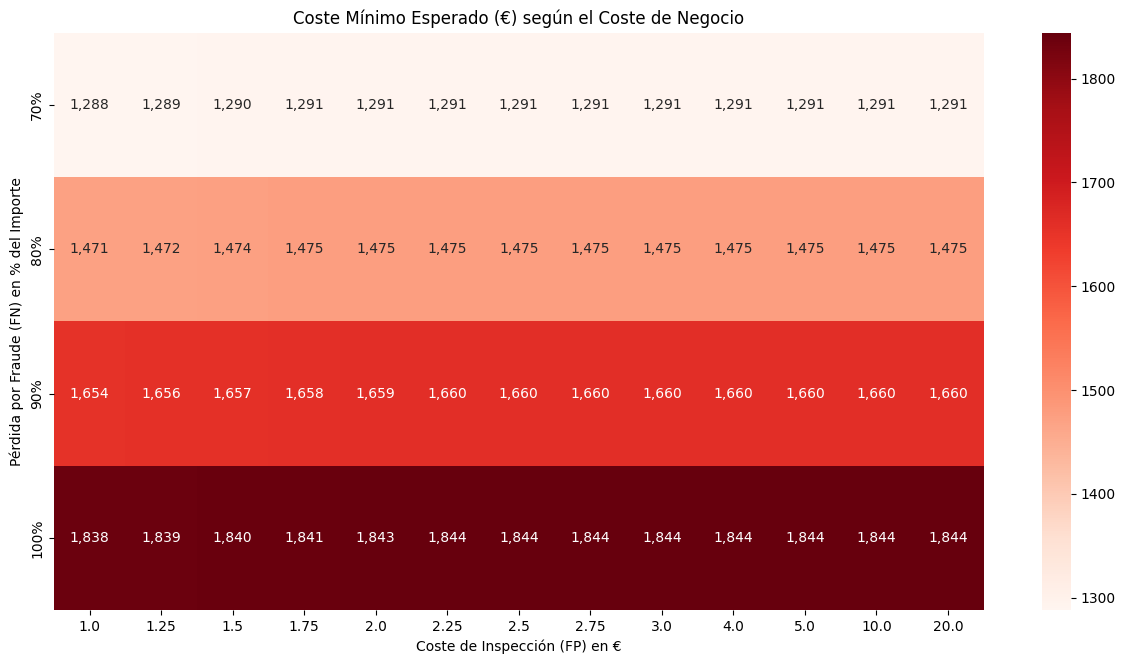

In [7]:
# Pivotar la tabla para el heatmap de costes
cost_pivot = sensitivity_df.pivot(
    index='fraud_loss_pct', 
    columns='inspect_cost_eur', 
    values='min_expected_cost'
)

orden_deseado = ['70%', '80%', '90%', '100%']
cost_pivot = cost_pivot.reindex(orden_deseado)

plt.figure(figsize=(15, 7.5))
sns.heatmap(cost_pivot, annot=True, fmt=",.0f", cmap="Reds")
plt.title("Coste Mínimo Esperado (€) según el Coste de Negocio")
plt.xlabel("Coste de Inspección (FP) en €")
plt.ylabel("Pérdida por Fraude (FN) en % del Importe")

# --- GUARDAR IMAGEN ---
output_path = '../results/heatmap_sensibilidad_costes.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


## 4. Conclusiones del Análisis de Sensibilidad

Los mapas de calor revelan la robustez y adaptabilidad del modelo **XGBoost (Factor 20)**:

1.  **Punto de Inflexión en 3€:**
    Hemos identificado un cambio de régimen claro en la estrategia de decisión:
    * **Coste de Inspección ≤ 2€:** La estrategia óptima es **Agresiva** (Umbral bajo: **0.4060**). Es rentable generar falsas alarmas para cazar más fraude.
    * **Coste de Inspección ≥ 3€:** La estrategia óptima es **Conservadora** (Umbral alto: **0.7821**). El coste de las falsas alarmas pesa más, por lo que solo se deben revisar transacciones con muy alta probabilidad de fraude.

2.  **Dominancia del Fraude Real:**
    El coste total (Gráfico 2) es altamente sensible al porcentaje de pérdida por fraude (Eje Y), variando de ~1.300€ a ~1.800€. Sin embargo, es notablemente insensible al coste de inspección (Eje X) una vez superados los 3€, gracias al ajuste dinámico del umbral.

**Recomendación Final:**
Dado el escenario base (`inspect_cost=5€`), nos situamos en la zona conservadora. La implementación final debe utilizar el modelo **XGBoost (Factor 20)** con un **umbral de decisión de 0.7821**, resultando en un coste esperado mínimo de **€1,660**.

## 5. Guardado del Modelo y Simulación de Producción

Una vez validada la estrategia, procedemos a guardar el modelo ganador y su configuración operativa para su hipotética puesta en producción.

1.  **Guardamos** el modelo entrenado (**XGBoost** con `amount_factor=20`).
2.  **Simulamos** la predicción sobre 5 transacciones aleatorias usando el umbral operativo (**0.7821**).

In [8]:

# 1. Crear carpeta de modelos si no existe
if not os.path.exists('../models'):
    os.makedirs('../models')

# 2. Definir la configuración ganadora
FINAL_THRESHOLD = 0.7821 
FINAL_MODEL = xgb_best_model # El modelo que ya entrenamos al principio del notebook

# 3. Guardar el modelo
model_filename = '../models/fraud_detection_xgboost_final.pkl'
joblib.dump(FINAL_MODEL, model_filename)
print(f"Modelo guardado exitosamente en: {model_filename}")

# 4. Simulación de Inferencia (Producción)
print("\n--- SIMULACIÓN DE INFERENCIA ---")
print(f"Configuración cargada: Umbral de corte = {FINAL_THRESHOLD}")

# Seleccionar 5 muestras aleatorias del set de prueba
random_indices = np.random.choice(X_test.index, 1000, replace=False)
sample_data = X_test.loc[random_indices]
sample_amounts = amount_test.loc[random_indices]
sample_true_labels = y_test.loc[random_indices]

# Predecir probabilidad
sample_probs = FINAL_MODEL.predict_proba(sample_data)[:, 1]

print("\n{:<10} | {:<10} | {:<15} | {:<15} | {:<10}".format(
    "ID Trans.", "Importe", "Probabilidad", "Predicción", "Realidad"
))
print("-" * 75)

for i, (idx, amt, prob, true_label) in enumerate(zip(random_indices, sample_amounts, sample_probs, sample_true_labels)):
    # APLICAMOS EL UMBRAL DE NEGOCIO
    is_fraud_pred = "🚨 FRAUDE" if prob >= FINAL_THRESHOLD else "✅ LEGÍTIMA"
    is_fraud_real = "🚨 FRAUDE" if true_label == 1 else "✅ LEGÍTIMA"
    
    print("{:<10} | €{:<9.2f} | {:<15.4f} | {:<15} | {:<10}".format(
        idx, amt, prob, is_fraud_pred, is_fraud_real
    ))

Modelo guardado exitosamente en: ../models/fraud_detection_xgboost_final.pkl

--- SIMULACIÓN DE INFERENCIA ---
Configuración cargada: Umbral de corte = 0.7821

ID Trans.  | Importe    | Probabilidad    | Predicción      | Realidad  
---------------------------------------------------------------------------
223581     | €32.00     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
194960     | €1.00      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
214106     | €39.95     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
170106     | €35.00     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
210213     | €115.54    | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
261763     | €1.00      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
194691     | €0.99      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
45678      | €24.90     | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
3266       | €1.10      | 0.0000          | ✅ LEGÍTIMA      | ✅ LEGÍTIMA
57045      | €48.33     | 0.0000  

In [43]:
# ==============================================================================
# 1. CARGA Y RE-ENTRENAMIENTO DEL MODELO GANADOR (RF, Factor 4)
# ==============================================================================

print("--- 1. PREPARACIÓN DEL MODELO GANADOR ---")

# 1. Cargar datos
df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')

# 2. Simular 'Monto del Préstamo' (Igual que en análisis financiero)
# (MonthlyIncome * 12 meses)
median_income = X_cs['MonthlyIncome'].median()
incomes = X_cs['MonthlyIncome'].fillna(median_income)
loan_amounts = incomes * 12 

# 3. Split Train/Test
# Importante: amount_factor=4 requiere que pasemos los montos al entrenamiento
X_train, X_test, y_train, y_test, amt_train, amt_test = train_test_split(
    X_cs, y_cs, loan_amounts, test_size=0.2, stratify=y_cs, random_state=42
)

# 4. ENTRENAR EL MODELO GANADOR (Random Forest, Factor 4)
print("Entrenando Random Forest con amount_factor=4...")
rf_winner = train_model_with_cost(
    X_train, y_train, amt_train, 
    model_type="rf",        # El modelo ganador
    amount_factor=4         # El factor óptimo
)

# 5. Obtener probabilidades para el Test Set
probs_winner = rf_winner.predict_proba(X_test)[:, 1]

print(f"Modelo entrenado y predicciones listas. Tamaño Test: {len(X_test)}")

--- 1. PREPARACIÓN DEL MODELO GANADOR ---
Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $4,816,130,055
Entrenando Random Forest con amount_factor=4...
Model RF trained (factor=4)
Modelo entrenado y predicciones listas. Tamaño Test: 30000



--- 2. GENERANDO MATRIZ DE SENSIBILIDAD (LGD vs INTERÉS) ---


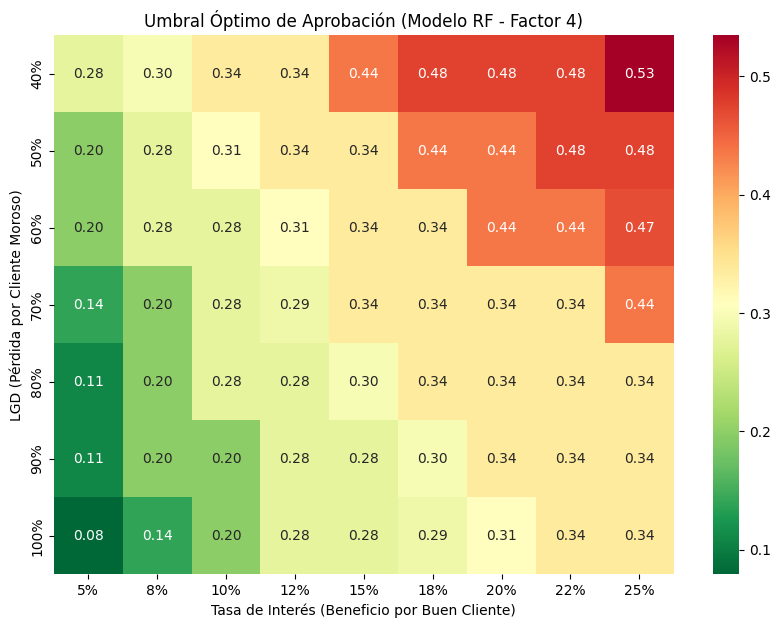

In [55]:
# ==============================================================================
# 2. ANÁLISIS DE SENSIBILIDAD: LGD vs TASA DE INTERÉS
# ==============================================================================

print("\n--- 2. GENERANDO MATRIZ DE SENSIBILIDAD (LGD vs INTERÉS) ---")

# Rangos de Escenarios Económicos
# LGD: Desde 40% (recuperamos mucho) hasta 100% (pérdida total)
lgd_range = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# Interés: Desde 5% (hipoteca barata) hasta 25% (tarjeta crédito/microcrédito)
interest_range = [0.05, 0.075, 0.10, 0.125, 0.15, 0.175, 0.20, 0.225, 0.25]

# Matriz para guardar el Umbral Óptimo
threshold_matrix = np.zeros((len(lgd_range), len(interest_range)))

# Barrido de escenarios
for i, lgd in enumerate(lgd_range):
    for j, rate in enumerate(interest_range):
        
        # Calcular costes:
        # Coste FN (Aprobamos a moroso) = Amount * LGD
        fn_costs = amt_test * lgd
        # Coste FP (Rechazamos a pagador) = Amount * Tasa Interés
        fp_costs = amt_test * rate
        
        # Buscar umbral que minimice la suma de pérdidas
        best_thr = 0.5
        min_cost = float('inf')
        
        # Probamos 100 cortes posibles
        for thr in np.linspace(0.01, 0.99, 100):
            y_pred = (probs_winner >= thr).astype(int)
            
            # Sumar pérdidas reales + lucro cesante
            current_fn = fn_costs[(y_test == 1) & (y_pred == 0)].sum()
            current_fp = fp_costs[(y_test == 0) & (y_pred == 1)].sum()
            
            if (current_fn + current_fp) < min_cost:
                min_cost = (current_fn + current_fp)
                best_thr = thr
        
        threshold_matrix[i, j] = best_thr

# Visualización
plt.figure(figsize=(10, 7))
sns.heatmap(threshold_matrix, annot=True, fmt=".2f", cmap="RdYlGn_r",
            xticklabels=[f"{x:.0%}" for x in interest_range],
            yticklabels=[f"{x:.0%}" for x in lgd_range])

plt.title(f"Umbral Óptimo de Aprobación (Modelo RF - Factor 4)")
plt.xlabel("Tasa de Interés (Beneficio por Buen Cliente)")
plt.ylabel("LGD (Pérdida por Cliente Moroso)")
plt.show()

In [54]:
# ==============================================================================
# 3. SELECCIÓN DE ESCENARIO Y SIMULACIÓN OPERATIVA
# ==============================================================================

# 1. Definir Escenario Base (Banco Estándar)
BASE_LGD = 1       # Perdemos el 80% si hay default
BASE_INTEREST = 0.05  # Ganamos 15% si pagan

# Obtener el umbral exacto para este escenario
# (Repetimos el cálculo rápido para tener el valor exacto en variable)
fn_costs = amt_test * BASE_LGD
fp_costs = amt_test * BASE_INTEREST
thresholds = np.linspace(0.01, 0.99, 100)
costs = []
for thr in thresholds:
    y_p = (probs_winner >= thr).astype(int)
    c = fn_costs[(y_test==1) & (y_p==0)].sum() + fp_costs[(y_test==0) & (y_p==1)].sum()
    costs.append(c)

final_threshold = thresholds[np.argmin(costs)]

print(f"\n--- ESCENARIO SELECCIONADO: LGD {BASE_LGD:.0%} | Interés {BASE_INTEREST:.0%} ---")
print(f"Umbral de Corte Operativo: {final_threshold:.3f}")
print("(Si Prob. Impago < Umbral -> APROBADO)")

# 2. Simulación con Clientes Reales (Test Set)
print("\n--- EJEMPLO DE DECISIONES DE CRÉDITO ---")
indices = np.random.choice(X_test.index, 1000, replace=False)

print("{:<8} | {:<12} | {:<10} | {:<12} | {:<12} | {}".format(
    "ID", "Préstamo", "Riesgo(%)", "Decisión", "Realidad", "Resultado Financiero"
))
print("-" * 95)

for idx in indices:
    amt = amt_test[idx]
    # Usamos acceso posicional seguro para las probabilidades
    loc_idx = X_test.index.get_loc(idx)
    prob = probs_winner[loc_idx]
    real = y_test.loc[idx]
    
    decision = "❌ RECHAZADO" if prob >= final_threshold else "✅ APROBADO"
    reality_txt = "💸 IMPAGO" if real == 1 else "👍 PAGÓ"
    
    msg = ""
    if decision == "✅ APROBADO":
        if real == 0: msg = f"✅ +{amt*BASE_INTEREST:,.0f}€ (Ganancia)"
        else:         msg = f"🛑 -{amt*BASE_LGD:,.0f}€ (PÉRDIDA CAPITAL)"
    else: # Rechazado
        if real == 0: msg = f"⚠️ 0€ (Dejamos de ganar {amt*BASE_INTEREST:,.0f}€)"
        else:         msg = f"🛡️ 0€ (Ahorro de {amt*BASE_LGD:,.0f}€)"

    print("{:<8} | €{:<11,.0f} | {:<10.1%} | {:<12} | {:<12} | {}".format(
        idx, amt, prob, decision, reality_txt, msg
    ))


--- ESCENARIO SELECCIONADO: LGD 100% | Interés 5% ---
Umbral de Corte Operativo: 0.079
(Si Prob. Impago < Umbral -> APROBADO)

--- EJEMPLO DE DECISIONES DE CRÉDITO ---
ID       | Préstamo     | Riesgo(%)  | Decisión     | Realidad     | Resultado Financiero
-----------------------------------------------------------------------------------------------
44115    | €64,800      | 1.5%       | ✅ APROBADO   | 👍 PAGÓ       | ✅ +3,240€ (Ganancia)
22716    | €64,800      | 0.5%       | ✅ APROBADO   | 👍 PAGÓ       | ✅ +3,240€ (Ganancia)
119325   | €108,000     | 3.0%       | ✅ APROBADO   | 👍 PAGÓ       | ✅ +5,400€ (Ganancia)
108071   | €15,600      | 8.5%       | ❌ RECHAZADO  | 👍 PAGÓ       | ⚠️ 0€ (Dejamos de ganar 780€)
41489    | €64,800      | 3.0%       | ✅ APROBADO   | 👍 PAGÓ       | ✅ +3,240€ (Ganancia)
106949   | €56,748      | 0.0%       | ✅ APROBADO   | 👍 PAGÓ       | ✅ +2,837€ (Ganancia)
84046    | €180,000     | 0.5%       | ✅ APROBADO   | 👍 PAGÓ       | ✅ +9,000€ (Ganancia)
103262

In [53]:
print("\n--- 4. GUARDANDO MODELO---")

# Parámetros ganadores del Análisis Financiero
winner_model = "rf"   # Random Forest
best_factor = 4       # Factor de penalización óptimo

print(f"Re-entrenando el modelo final ({winner_model.upper()}) con factor {best_factor}...")

# Entrenamos usando los datos de Credit Scoring cargados en este notebook
final_model_production = train_model_with_cost(
    X_train, y_train, amt_train, 
    model_type=winner_model, 
    amount_factor=best_factor
)

# Definimos la ruta (usamos un nombre distinto para diferenciarlo del de testing)
output_path = '../models/credit_scoring_final_model.pkl'

# Aseguramos que la carpeta exista
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Guardamos solo el modelo (sin metadatos extra, formato simple)
joblib.dump(final_model_production, output_path)

print(f"Modelo guardado exitosamente en: {output_path}")
print(f"Nota: Recuerda el umbral calculado ({final_threshold:.4f}) para usarlo en el siguiente paso.")


--- 4. GUARDANDO MODELO PARA PRODUCCIÓN/XAI ---
Re-entrenando el modelo final (RF) con factor 4...
Model RF trained (factor=4)
✅ Modelo guardado exitosamente en: ../models/credit_scoring_final_model.pkl
Nota: Recuerda el umbral calculado (0.1387) para usarlo en el siguiente paso.
